<a href="https://colab.research.google.com/github/petrusthelastking/TANDANG_GAWE_KUIS_ULO-PYTHON-/blob/main/UTS(21_10_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [10]:
!pip -q install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Import

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from annoy import AnnoyIndex
import random

# Load Data (Upload atau Path manual)

In [43]:
USE_UPLOAD = True     # True = upload via dialog Colab; False = baca dari DATA_PATH
DATA_PATH = '/content/train.csv'  # Pakai kalau USE_UPLOAD=False

if USE_UPLOAD:
    try:
        from google.colab import files
        uploaded = files.upload()  # pilih train.csv
        DATA_PATH = next(iter(uploaded))
        print('Menggunakan file upload:', DATA_PATH)
    except Exception as e:
        raise RuntimeError('Gagal upload. Set USE_UPLOAD=False dan isi DATA_PATH ke lokasi train.csv')

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head(3))
print('\nMissing values per column (top 15):')
print(df.isna().sum().sort_values(ascending=False).head(15))

Saving train.csv to train (2).csv
Menggunakan file upload: train (2).csv
Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500



Missing values per column (top 15):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
dtype: int64


# Feature Engineering khusus House Prices
- Drop kolom ID & Target
- Optional: TotalArea = GrLivArea + TotalBsmtSF

In [44]:
df_fe = df.copy()

# Tambah feature TotalArea kalau kolomnya ada
if {'GrLivArea','TotalBsmtSF'}.issubset(df_fe.columns):
    df_fe['TotalArea'] = df_fe['GrLivArea'] + df_fe['TotalBsmtSF']
    print('Feature dibuat: TotalArea = GrLivArea + TotalBsmtSF')

# Drop kolom ID & TARGET
ID_COLUMNS = ['Id']
TARGET = 'SalePrice'

df_fe = df_fe.drop(columns=[c for c in ID_COLUMNS if c in df_fe.columns], errors='ignore')
if TARGET in df_fe.columns:
    df_fe = df_fe.drop(columns=[TARGET])
    print('Drop target kolom:', TARGET)

display(df_fe.head(3))

Feature dibuat: TotalArea = GrLivArea + TotalBsmtSF
Drop target kolom: SalePrice


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalArea
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,2566
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,2524
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,2706


# Preprocessing

In [45]:
numeric_cols = df_fe.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
categorical_cols = [c for c in df_fe.columns if c not in numeric_cols]

print('Numeric cols:', len(numeric_cols))
print('Categorical cols:', len(categorical_cols))

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_num = pd.DataFrame(num_imputer.fit_transform(df_fe[numeric_cols]), columns=numeric_cols, index=df_fe.index)
if categorical_cols:
    _ = pd.DataFrame(cat_imputer.fit_transform(df_fe[categorical_cols]), columns=categorical_cols, index=df_fe.index)  # tidak dipakai

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numeric_cols, index=df_fe.index)

print('X_scaled shape:', X_scaled.shape)

Numeric cols: 37
Categorical cols: 43
X_scaled shape: (1460, 37)


# Helper evaluasi (aman untuk DBSCAN dengan noise)

In [46]:
# =========================================
# 4) Helper evaluasi (aman untuk DBSCAN dengan noise)
#    - Kembalikan silhouette, DBI, jumlah cluster (tanpa noise)
# =========================================
def eval_labels(X: np.ndarray, labels: np.ndarray):
    out = {
        "silhouette": np.nan,
        "dbi": np.nan,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    }
    # Perlu >=2 cluster untuk evaluasi
    if len(set(labels)) <= 1:
        return out

    # Coba evaluasi pada non-noise dulu
    mask = labels != -1
    try_mask = (mask.sum() >= 2) and (len(set(labels[mask])) >= 2)
    try_full = len(set(labels)) >= 2

    if try_mask:
        try:
            out["silhouette"] = float(silhouette_score(X[mask], labels[mask]))
        except Exception:
            pass
        try:
            out["dbi"] = float(davies_bouldin_score(X[mask], labels[mask]))
        except Exception:
            pass
    elif try_full:
        try:
            out["silhouette"] = float(silhouette_score(X, labels))
            out["dbi"] = float(davies_bouldin_score(X, labels))
        except Exception:
            pass

    return out


# KMeans: cari k terbaik (2..10) via silhouette

In [47]:
X = X_scaled.values.astype('float32')
best_kmeans, best_k, best_k_metrics = None, None, None

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    m = eval_labels(X, labels)
    if best_k_metrics is None or (np.nan_to_num(m['silhouette'], nan=-1) > np.nan_to_num(best_k_metrics['silhouette'], nan=-1)):
        best_kmeans, best_k, best_k_metrics = km, k, m

labels_kmeans = best_kmeans.labels_
print(f"Best KMeans k={best_k} → silhouette={best_k_metrics['silhouette']:.4f}, DBI={best_k_metrics['dbi']:.4f}, clusters={best_k_metrics['n_clusters']}")

Best KMeans k=2 → silhouette=0.1471, DBI=2.2830, clusters=2


# DBSCAN: grid kecil eps & min_samples → pilih terbaik

In [48]:
param_grid_eps = [0.3, 0.5, 0.7, 1.0, 1.3]
param_grid_min = [5, 10]

best_db, best_db_params, best_db_metrics = None, None, None

for eps in param_grid_eps:
    for ms in param_grid_min:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)
        m = eval_labels(X, labels)
        if best_db_metrics is None:
            best_db, best_db_params, best_db_metrics = db, (eps, ms), m
        else:
            curr = (np.nan_to_num(m['silhouette'], nan=-1), -np.nan_to_num(m['dbi'], nan=np.inf))
            prev = (np.nan_to_num(best_db_metrics['silhouette'], nan=-1), -np.nan_to_num(best_db_metrics['dbi'], nan=np.inf))
            if curr > prev:
                best_db, best_db_params, best_db_metrics = db, (eps, ms), m

labels_dbscan = best_db.fit_predict(X)
print(f"Best DBSCAN eps={best_db_params[0]}, min_samples={best_db_params[1]} → silhouette={best_db_metrics['silhouette']:.4f}, DBI={best_db_metrics['dbi']:.4f}, clusters={best_db_metrics['n_clusters']}")

Best DBSCAN eps=0.3, min_samples=5 → silhouette=nan, DBI=nan, clusters=0


# Diagnostics & Adaptive Search

In [49]:
# === 6A) DBSCAN Adaptive Search (compact) ===
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

def dbscan_adapt(X_scaled, labels_init, best_metrics,
                 metrics=("euclidean","manhattan","cosine"),
                 ks=(3,5,8,12), percentiles=(92,94,96,98),
                 pca_dims=(None,5)):
    """Cari setting DBSCAN yang lebih baik (silhouette↑, DBI↓) bila hasil awal jelek."""
    def eval_masked(X, lab):
        n = len(set(lab)) - (1 if -1 in lab else 0)
        if n < 2: return -1.0, np.inf, n
        m = (lab != -1)
        if m.sum() >= 2 and len(set(lab[m])) >= 2:
            try:
                return silhouette_score(X[m], lab[m]), davies_bouldin_score(X[m], lab[m]), n
            except: pass
        return -1.0, np.inf, n

    best = {
        "sil": np.nan_to_num((best_metrics or {}).get("silhouette", -1), nan=-1.0),
        "dbi": (best_metrics or {}).get("dbi", np.inf),
        "labels": labels_init, "eps": None, "min_samples": None,
        "metric": "euclidean", "space": "raw"
    }

    need = (best["sil"] < 0) or (len(set(labels_init)) - (1 if -1 in labels_init else 0) < 2) or ((labels_init == -1).mean() > 0.95)
    if not need:
        return best  # hasil awal sudah oke

    for dim in pca_dims:
        X = X_scaled if dim is None else PCA(n_components=dim, random_state=42).fit_transform(X_scaled)
        for metric in metrics:
            for k in ks:
                nn = NearestNeighbors(n_neighbors=k, metric="cosine" if metric=="cosine" else metric).fit(X)
                kd = np.sort(nn.kneighbors(X)[0][:, -1])  # jarak ke tetangga ke-k
                for p in percentiles:
                    eps = float(np.percentile(kd, p))
                    lab = DBSCAN(eps=eps, min_samples=int(k), metric=metric).fit_predict(X)
                    sil, dbi, nclus = eval_masked(X, lab)
                    if nclus >= 2 and (sil > best["sil"] or (np.isclose(sil, best["sil"]) and dbi < best["dbi"])):
                        best.update({"sil": float(sil), "dbi": float(dbi), "labels": lab,
                                     "eps": eps, "min_samples": int(k),
                                     "metric": metric, "space": ("raw" if dim is None else f"pca{dim}")})
    return best

# --- Pakai di notebook kamu (update variabel global jika ada perbaikan) ---
res = dbscan_adapt(X_scaled.values, labels_dbscan, best_db_metrics)
if res["labels"] is not None and (res["labels"] is not labels_dbscan) and res["sil"] >= 0:
    labels_dbscan = res["labels"]
    best_db_params = (res["eps"], res["min_samples"])
    best_db_metrics = {
        "silhouette": res["sil"],
        "dbi": res["dbi"],
        "n_clusters": len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0),
    }
    chosen_metric = res["metric"]
    print(f"[ADAPT] space={res['space']}, metric={chosen_metric}, eps={res['eps']:.3f}, "
          f"min_samples={res['min_samples']} → sil={res['sil']:.4f}, dbi={res['dbi']:.4f}, "
          f"clusters={best_db_metrics['n_clusters']}, noise={(labels_dbscan==-1).mean():.1%}")
else:
    chosen_metric = "euclidean"
    print("DBSCAN awal sudah OK atau belum ditemukan setting yang lebih baik.")


[ADAPT] space=pca5, metric=manhattan, eps=4.505, min_samples=3 → sil=0.3276, dbi=0.7011, clusters=2, noise=1.5%


# Visualisasi PCA 2D (KMeans & DBSCAN)

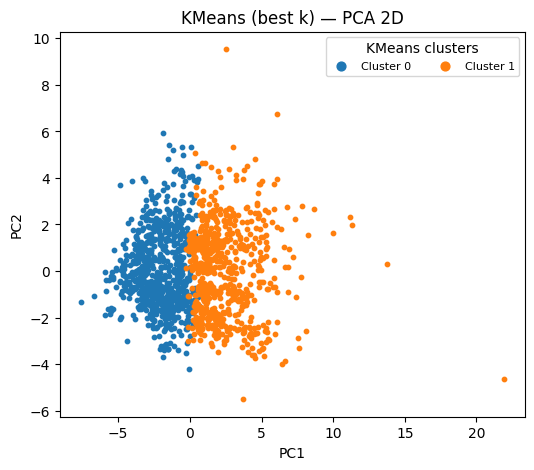

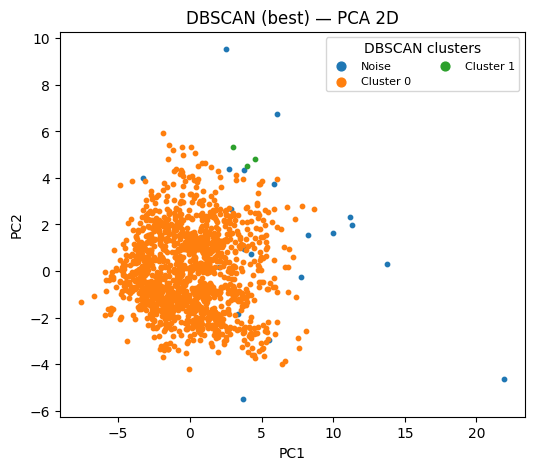

In [50]:
# === PCA 2D + LEGEND ===
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled.values)

# --- KMEANS ---
plt.figure(figsize=(6,5))
unique_k = np.unique(labels_kmeans)
for k in unique_k:
    mask = (labels_kmeans == k)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, label=f'Cluster {k}')
plt.title('KMeans (best k) — PCA 2D')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(title='KMeans clusters', loc='best', ncol=2, fontsize=8, markerscale=2)
plt.show()

# --- DBSCAN (tampilkan "Noise" utk label -1) ---
plt.figure(figsize=(6,5))
unique_d = np.unique(labels_dbscan)
for k in unique_d:
    mask = (labels_dbscan == k)
    label = 'Noise' if k == -1 else f'Cluster {k}'
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, label=label)
plt.title('DBSCAN (best) — PCA 2D')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(title='DBSCAN clusters', loc='best', ncol=2, fontsize=8, markerscale=2)
plt.show()


# Approximate Nearest Neighbor (Annoy)

In [39]:
dim = X.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Ensure X is the correct scaled data (89 dimensions)
X = X_scaled.values.astype('float32')

for i, vec in enumerate(X): # Use the original scaled data X
    ann.add_item(i, vec)
ann.build(20)  # jumlah tree (boleh diubah)

random.seed(42)
query_indices = random.sample(range(len(X)), k=min(3, len(X)))
print('Query indices:', query_indices)

for q in query_indices:
    neighbors, distances = ann.get_nns_by_item(q, 6, include_distances=True)  # termasuk diri sendiri
    print(f"\nQuery Point Index: {q}")
    print("Nearest Neighbors and Distances:")
    for n, d in zip(neighbors, distances):
        print(f"Neighbor Index: {n} | Distance: {d:.4f} | KMeans: {labels_kmeans[n]} | DBSCAN: {labels_dbscan[n]}")

Query indices: [1309, 228, 51]

Query Point Index: 1309
Nearest Neighbors and Distances:
Neighbor Index: 1309 | Distance: 0.0000 | KMeans: 1 | DBSCAN: 0
Neighbor Index: 67 | Distance: 2.0862 | KMeans: 1 | DBSCAN: 0
Neighbor Index: 752 | Distance: 2.1490 | KMeans: 1 | DBSCAN: 0
Neighbor Index: 356 | Distance: 2.3680 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 133 | Distance: 2.3949 | KMeans: 1 | DBSCAN: 0
Neighbor Index: 1146 | Distance: 2.4661 | KMeans: 1 | DBSCAN: 0

Query Point Index: 228
Nearest Neighbors and Distances:
Neighbor Index: 228 | Distance: 0.0000 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 288 | Distance: 2.2813 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 884 | Distance: 2.3315 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 917 | Distance: 2.9254 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 1261 | Distance: 2.9564 | KMeans: 0 | DBSCAN: 0
Neighbor Index: 19 | Distance: 2.9585 | KMeans: 0 | DBSCAN: 0

Query Point Index: 51
Nearest Neighbors and Distances:
Neighbor Index: 51 | Distance: 0.0000 | K

In [52]:
# === ANN (Annoy) – Tabel Hasil untuk Laporan ===
import numpy as np, pandas as pd, random
from annoy import AnnoyIndex

# 1) Bangun index Annoy kalau belum ada
dim = X_scaled.shape[1]
if 'ann' not in globals():
    ann = AnnoyIndex(dim, 'euclidean')
    for i, vec in enumerate(X_scaled.values):
        ann.add_item(i, vec.tolist())
    ann.build(20)

# 2) Pilih 3 query (pakai yang sudah ada, kalau belum ambil acak)
try:
    qidx = list(query_indices)
except NameError:
    random.seed(42)
    qidx = random.sample(range(X_scaled.shape[0]), k=3)

# 3) Kumpulkan 5 tetangga terdekat per query (tanpa diri sendiri)
rows = []
for q in qidx:
    nns, dists = ann.get_nns_by_item(q, 6, include_distances=True)  # termasuk diri sendiri
    for n, d in zip(nns, dists):
        if n == q:  # buang diri sendiri
            continue
        rows.append({
            "Query": q,
            "Neighbor": n,
            "Distance": round(float(d), 4),
            "KMeans_Cluster": int(labels_kmeans[n]),
            "DBSCAN_Cluster": int(labels_dbscan[n]),
        })
df_ann = (pd.DataFrame(rows)
          .groupby("Query", as_index=False)
          .apply(lambda g: g.nsmallest(5, "Distance"))
          .reset_index(drop=True))

# 4) Konsistensi tetangga per query (opsional buat laporan)
def km_consistency(df):
    out=[]
    for q,g in df.groupby("Query"):
        same = (labels_kmeans[g["Neighbor"].values] == labels_kmeans[q]).sum()
        out.append({"Query": q, "KMeans_consistency": round(same/len(g), 3)})
    return pd.DataFrame(out)

def db_consistency(df):
    out=[]
    for q,g in df.groupby("Query"):
        qlab = labels_dbscan[q]
        valid = [n for n in g["Neighbor"].values if labels_dbscan[n] != -1 and qlab != -1]
        if valid:
            same = sum(labels_dbscan[n] == qlab for n in valid)
            out.append({"Query": q, "DBSCAN_consistency": round(same/len(valid), 3), "valid_neighbors": len(valid)})
        else:
            out.append({"Query": q, "DBSCAN_consistency": None, "valid_neighbors": 0})
    return pd.DataFrame(out)

df_km = km_consistency(df_ann)
df_db = db_consistency(df_ann)

# 5) Tampilkan & simpan (mudah dicopy ke Word)
display(df_ann)
display(df_km)
display(df_db)

df_ann.to_csv("ann_neighbors_table.csv", index=False)
df_km.to_csv("ann_kmeans_consistency.csv", index=False)
df_db.to_csv("ann_dbscan_consistency.csv", index=False)

print("Saved: ann_neighbors_table.csv, ann_kmeans_consistency.csv, ann_dbscan_consistency.csv")


/tmp/ipython-input-2175817819.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nsmallest(5, "Distance"))


,Query,Neighbor,Distance,KMeans_Cluster,DBSCAN_Cluster
0,51,873,4.7750,0,0
1,51,729,5.2472,0,0
2,51,406,5.3116,0,0
3,51,170,5.3393,0,0
4,51,589,5.5336,0,0
5,228,288,2.2813,0,0
6,228,884,2.3315,0,0
7,228,917,2.9254,0,0
8,228,1261,2.9564,0,0
9,228,19,2.9585,0,0


,Query,KMeans_consistency
0,51,1.0
1,228,1.0
2,1309,0.8


,Query,DBSCAN_consistency,valid_neighbors
0,51,1.0,5
1,228,1.0,5
2,1309,1.0,5


Saved: ann_neighbors_table.csv, ann_kmeans_consistency.csv, ann_dbscan_consistency.csv


# Konsistensi tetangga Annoy dengan label klaster

In [53]:
def neighbor_consistency(labels, neighbors_dict):
    out = []
    for q, (nns, dists) in neighbors_dict.items():
        neigh = [n for n in nns if n != q]
        if not neigh:
            out.append((q, float('nan')))
            continue
        same = sum(labels[n] == labels[q] for n in neigh)
        out.append((q, same/len(neigh)))
    return out

neighbors_dict = {}
for q in query_indices:
    nns, dists = ann.get_nns_by_item(q, 6, include_distances=True)
    neighbors_dict[q] = (nns, dists)

print("KMEANS neighbor consistency:")
for q, rate in neighbor_consistency(labels_kmeans, neighbors_dict):
    print(f"q={q} -> {rate:.2%}")

print("\nDBSCAN neighbor consistency (abaikan noise):")
for q, (nns, dists) in neighbors_dict.items():
    neigh = [n for n in nns if n != q]
    valid = [n for n in neigh if labels_dbscan[n] != -1 and labels_dbscan[q] != -1]
    if not valid:
        print(f"q={q} -> N/A (noise)")
        continue
    same = sum(labels_dbscan[n] == labels_dbscan[q] for n in valid)
    print(f"q={q} -> {same/len(valid):.2%} (dari {len(valid)} tetangga valid)")

KMEANS neighbor consistency:
q=1309 -> 80.00%
q=228 -> 100.00%
q=51 -> 100.00%

DBSCAN neighbor consistency (abaikan noise):
q=1309 -> 100.00% (dari 5 tetangga valid)
q=228 -> 100.00% (dari 5 tetangga valid)
q=51 -> 100.00% (dari 5 tetangga valid)


# Ringkasan

In [54]:
print('\n=== RINGKASAN ===')
print(f"KMeans terbaik — k={best_k}: silhouette={best_k_metrics['silhouette']:.4f}, DBI={best_k_metrics['dbi']:.4f}")
print(f"DBSCAN terbaik — eps={best_db_params[0]}, min_samples={best_db_params[1]}: silhouette={best_db_metrics['silhouette']:.4f}, DBI={best_db_metrics['dbi']:.4f}, n_clusters={best_db_metrics['n_clusters']}")
print('Cek apakah tetangga Annoy cenderung berada pada cluster yang sama (lihat label di atas).')


=== RINGKASAN ===
KMeans terbaik — k=2: silhouette=0.1471, DBI=2.2830
DBSCAN terbaik — eps=4.505354976502123, min_samples=3: silhouette=0.3276, DBI=0.7011, n_clusters=2
Cek apakah tetangga Annoy cenderung berada pada cluster yang sama (lihat label di atas).


# PERCOBAAN UNTUK KEBUTUHAN KOMPETISI (KEGGLE)

## PERCOBAAN 1 (0.12451)

In [22]:
# ==== FAST BOOST KAGGLE: LightGBM + Ridge (blend) ====
!pip -q install lightgbm

import os, time, numpy as np, pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor

# -- Load (upload jika belum ada) --
TRAIN_PATH, TEST_PATH = "/content/train.csv", "/content/test.csv"
if not (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    from google.colab import files
    print("Upload train.csv lalu test.csv (dari halaman kompetisi).")
    up = files.upload();  TRAIN_PATH = "train.csv" if "train.csv" in up else list(up.keys())[0]
    up = files.upload();  TEST_PATH  = "test.csv"  if "test.csv"  in up else list(up.keys())[0]

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# -- Feature engineering ringkas (aman & umum) --
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Total luas lantai
    for cols, name in [
        (["TotalBsmtSF","1stFlrSF","2ndFlrSF"], "TotalSF"),
    ]:
        if all(c in out.columns for c in cols):
            out[name] = sum(out[c] for c in cols)
    # Kamar mandi total (basement dihitung)
    for cols, name in [
        (["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"], "TotalBaths")
    ]:
        if all(c in out.columns for c in cols):
            fb = out["FullBath"] if "FullBath" in out else 0
            hb = out["HalfBath"] if "HalfBath" in out else 0
            bfb = out["BsmtFullBath"] if "BsmtFullBath" in out else 0
            bhb = out["BsmtHalfBath"] if "BsmtHalfBath" in out else 0
            out[name] = fb + 0.5*hb + bfb + 0.5*bhb
    # Umur & renovasi
    if "YrSold" in out.columns and "YearBuilt" in out.columns:
        out["Age"] = (out["YrSold"] - out["YearBuilt"]).clip(lower=0)
    if "YrSold" in out.columns and "YearRemodAdd" in out.columns:
        out["RemodAge"] = (out["YrSold"] - out["YearRemodAdd"]).clip(lower=0)
        out["IsRemodeled"] = (out["YearRemodAdd"] > out.get("YearBuilt", out["YearRemodAdd"])).astype(int)
    # Porch/Deck total & indikator basement/garasi
    comp = ["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","WoodDeckSF"]
    out["TotalPorchSF"] = out[comp].sum(axis=1, min_count=1) if set(comp).issubset(out.columns) else 0
    if "TotRmsAbvGrd" in out.columns and "GrLivArea" in out.columns:
        out["RoomsPerArea"] = out["TotRmsAbvGrd"]/(out["GrLivArea"]+1e-9)
    if "TotalBsmtSF" in out.columns: out["HasBsmt"]  = (out["TotalBsmtSF"]>0).astype(int)
    if "GarageArea"  in out.columns: out["HasGarage"] = (out["GarageArea"]>0).astype(int)
    # MSSubClass sebagai kategori (bukan numerik)
    if "MSSubClass" in out.columns:
        out["MSSubClass"] = out["MSSubClass"].astype(str)
    return out

train = add_features(train)
test  = add_features(test)

# -- Split & outlier trimming ringan (GrLivArea ekor-kanan) --
y = np.log1p(train["SalePrice"].values)          # target di log-space (sesuai evaluasi Kaggle)
X = train.drop(columns=["SalePrice"])

if "GrLivArea" in X.columns:
    thr = X["GrLivArea"].quantile(0.995)        # buang 0.5% terbesar (kasar)
    keep = X["GrLivArea"] <= thr
    X, y = X.loc[keep].copy(), y[keep]

# -- Kolom numerik/kategorik --
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# -- Preprocess (shared) --
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])           # scaling bantu Ridge
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# -- Model 1: RidgeCV (kuat utk linear + one-hot) --
ridge = RidgeCV(alphas=[0.1,0.3,1.0,3.0,10.0], cv=5)
pipe_ridge = Pipeline([("pre", preprocess), ("model", ridge)])

# -- Model 2: LightGBM (bagus utk non-linear) --
#    Pakai one-hot yang sama agar simpel/aman di Colab
lgbm = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.1,
    random_state=42
)
pipe_lgb = Pipeline([("pre", preprocess), ("model", lgbm)])

# -- CV (perkiraan skor leaderboard; RMSE log) --
def rmse_log_cv(pipe, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    return scores.mean(), scores.std()

mean_ridge, std_ridge = rmse_log_cv(pipe_ridge, X, y)
mean_lgb,   std_lgb   = rmse_log_cv(pipe_lgb,   X, y)
print(f"Ridge  CV RMSE(log): {mean_ridge:.5f} ± {std_ridge:.5f}")
print(f"LGBM   CV RMSE(log): {mean_lgb:.5f} ± {std_lgb:.5f}")

# -- Fit full data & prediksi test --
pipe_ridge.fit(X, y)
pipe_lgb.fit(X, y)

X_test = test[X.columns]  # selaraskan kolom
pred_ridge_log = pipe_ridge.predict(X_test)
pred_lgb_log   = pipe_lgb.predict(X_test)

# -- Blend (sering lebih stabil di LB): 0.6*LGBM + 0.4*Ridge --
pred_log = 0.6*pred_lgb_log + 0.4*pred_ridge_log
pred = np.expm1(pred_log)

sub = pd.DataFrame({"Id": test["Id"], "SalePrice": pred})
ts = int(time.time())
fname = f"submission_blend_lgb_ridge_{ts}.csv"
sub.to_csv(fname, index=False)
print("Saved:", fname)
sub.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4393
[LightGBM] [Info] Number of data points in the train set: 1161, number of used features: 196
[LightGBM] [Info] Start training from score 12.024598


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4397
[LightGBM] [Info] Number of data points in the train set: 1161, number of used features: 195
[LightGBM] [Info] Start training from score 12.022471


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4359
[LightGBM] [Info] Number of data points in the train set: 1162, number of used features: 193
[LightGBM] [Info] Start training from score 12.014896


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4399
[LightGBM] [Info] Number of data points in the train set: 1162, number of used features: 197
[LightGBM] [Info] Start training from score 12.020904


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 1162, number of used features: 193
[LightGBM] [Info] Start training from score 12.013891


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Ridge  CV RMSE(log): 0.11228 ± 0.01489
LGBM   CV RMSE(log): 0.12448 ± 0.01349
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4577
[LightGBM] [Info] Number of data points in the train set: 1452, number of used features: 207
[LightGBM] [Info] Start training from score 12.019350


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Saved: submission_blend_lgb_ridge_1761009610.csv


,Id,SalePrice
0,1461,120554.864485
1,1462,155619.255729
2,1463,180626.242507
3,1464,193832.868570
4,1465,189776.019633


## PERCOBAAN DUA (0.12626)

In [23]:
# ==== SUPER-BASELINE 2.0: STACKING (Ridge + LightGBM + XGBoost) ====
!pip -q install lightgbm xgboost

import os, time, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# ---- Load train/test (pakai file kaggle) ----
TRAIN_PATH, TEST_PATH = "/content/train.csv", "/content/test.csv"
if not (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    from google.colab import files
    print("Upload train.csv lalu test.csv (dari halaman kompetisi).")
    up = files.upload();  TRAIN_PATH = "train.csv" if "train.csv" in up else list(up.keys())[0]
    up = files.upload();  TEST_PATH  = "test.csv"  if "test.csv"  in up else list(up.keys())[0]

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# ---- Feature engineering ringkas & aman ----
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # total floor area
    for cols, name in [ (["TotalBsmtSF","1stFlrSF","2ndFlrSF"], "TotalSF") ]:
        if all(c in out.columns for c in cols):
            out[name] = sum(out[c] for c in cols)
    # total bath (basement dihitung setengah utk half bath)
    if set(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]).issubset(out.columns):
        out["TotalBaths"] = out["FullBath"] + 0.5*out["HalfBath"] + out["BsmtFullBath"] + 0.5*out["BsmtHalfBath"]
    # umur rumah & umur sejak renovasi
    if "YrSold" in out.columns and "YearBuilt" in out.columns:
        out["Age"] = (out["YrSold"] - out["YearBuilt"]).clip(lower=0)
    if "YrSold" in out.columns and "YearRemodAdd" in out.columns:
        out["RemodAge"] = (out["YrSold"] - out["YearRemodAdd"]).clip(lower=0)
        out["IsRemodeled"] = (out["YearRemodAdd"] > out.get("YearBuilt", out["YearRemodAdd"])).astype(int)
    # total porch/deck
    comp = ["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","WoodDeckSF"]
    if set(comp).issubset(out.columns):
        out["TotalPorchSF"] = out[comp].sum(axis=1)
    # density rooms
    if "TotRmsAbvGrd" in out.columns and "GrLivArea" in out.columns:
        out["RoomsPerArea"] = out["TotRmsAbvGrd"]/(out["GrLivArea"]+1e-9)
    # indikator bsmt/garage
    if "TotalBsmtSF" in out.columns: out["HasBsmt"]  = (out["TotalBsmtSF"]>0).astype(int)
    if "GarageArea"  in out.columns: out["HasGarage"] = (out["GarageArea"]>0).astype(int)
    # jadikan MSSubClass kategori
    if "MSSubClass" in out.columns:
        out["MSSubClass"] = out["MSSubClass"].astype(str)
    return out

train = add_features(train)
test  = add_features(test)

# ---- Target & trimming outlier ringan ----
y = np.log1p(train["SalePrice"].values)
X = train.drop(columns=["SalePrice"]).copy()

if "GrLivArea" in X.columns:
    thr_hi = X["GrLivArea"].quantile(0.995)  # buang 0.5% terbesar (kasar; aman)
    keep = X["GrLivArea"] <= thr_hi
    X, y = X.loc[keep].reset_index(drop=True), y[keep]

# ---- Tipe fitur ----
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# ---- Preprocess (shared) ----
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  OneHotEncoder(handle_unknown="ignore"))]) # Removed sparse=False

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# ---- Model defs ----
ridge = RidgeCV(alphas=[0.1,0.3,1.0,3.0,10.0], cv=5)
lgb   = LGBMRegressor(
    n_estimators=2000, learning_rate=0.03, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.1,
    random_state=42
)
xgb   = XGBRegressor(
    n_estimators=2500, learning_rate=0.03, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    objective="reg:squarederror", tree_method="hist", random_state=42
)

models = {
    "ridge": Pipeline([("pre", pre), ("m", ridge)]),
    "lgb":   Pipeline([("pre", pre), ("m", lgb)]),
    "xgb":   Pipeline([("pre", pre), ("m", xgb)]),
}

# ---- Stratified CV by y-bins (stabil) ----
bins = pd.qcut(y, q=12, labels=False, duplicates="drop")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof = {k: np.zeros(len(X)) for k in models}
test_preds = {k: np.zeros(len(test)) for k in models}
scores = {}

for name, pipe in models.items():
    fold_rmse = []
    for fold, (tr, va) in enumerate(skf.split(X, bins), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y[tr], y[va]
        pipe.fit(Xtr, ytr)
        p_va = pipe.predict(Xva)
        p_te = pipe.predict(test)
        oof[name][va] = p_va
        test_preds[name] += p_te / skf.n_splits
        rmse = mean_squared_error(yva, p_va)
        fold_rmse.append(rmse)
        print(f"{name} | fold {fold} RMSE(log): {rmse:.5f}")
    scores[name] = (np.mean(fold_rmse), np.std(fold_rmse))
    print(f"==> {name} CV RMSE(log): {scores[name][0]:.5f} ± {scores[name][1]:.5f}\n")

# ---- Cari bobot optimal (grid kecil) di OOF ----
def best_weights(oof_dict, y_true, step=0.05):
    keys = list(oof_dict.keys())
    best = (9e9, None)
    # 3-model blend: w1,w2,w3 >= 0 dan jumlah = 1
    ws = np.arange(0, 1+1e-9, step)
    for w1 in ws:
        for w2 in ws:
            w3 = 1 - w1 - w2
            if w3 < -1e-9:
                continue
            pred = w1*oof_dict[keys[0]] + w2*oof_dict[keys[1]] + w3*oof_dict[keys[2]]
            rmse = mean_squared_error(y_true, pred)
            if rmse < best[0]:
                best = (rmse, (w1, w2, w3))
    return best

rmse_blend, w = best_weights(oof, y, step=0.05)
print(f"Best blend OOF RMSE(log): {rmse_blend:.5f} with weights (ridge,lgb,xgb) = {w}")

# ---- Produksi prediksi test pakai bobot terbaik ----
w_r, w_l, w_x = w
pred_log = w_r*test_preds["ridge"] + w_l*test_preds["lgb"] + w_x*test_preds["xgb"]
pred = np.expm1(pred_log)

sub = pd.DataFrame({"Id": test["Id"], "SalePrice": pred})
fname = f"submission_stack_blend_{int(time.time())}.csv"
sub.to_csv(fname, index=False)
print("Saved:", fname)
sub.head()

ridge | fold 1 RMSE(log): 0.01289
ridge | fold 2 RMSE(log): 0.01073
ridge | fold 3 RMSE(log): 0.01704
ridge | fold 4 RMSE(log): 0.01067
ridge | fold 5 RMSE(log): 0.01216
==> ridge CV RMSE(log): 0.01270 ± 0.00233

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4390
[LightGBM] [Info] Number of data points in the train set: 1161, number of used features: 197
[LightGBM] [Info] Start training from score 12.019530


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


lgb | fold 1 RMSE(log): 0.01595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4397
[LightGBM] [Info] Number of data points in the train set: 1161, number of used features: 196
[LightGBM] [Info] Start training from score 12.019211


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


lgb | fold 2 RMSE(log): 0.01195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 1162, number of used features: 192
[LightGBM] [Info] Start training from score 12.020375


KeyboardInterrupt: 

## PERCOBAAN 3 (0.12268)

In [ ]:
# ==== SUPER-BASELINE 3.0: Better FE + Ordinal + Separate Preprocess + Fine Blend ====
!pip -q install lightgbm xgboost

import os, time, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# ---- Load ----
TRAIN_PATH, TEST_PATH = "/content/train.csv", "/content/test.csv"
if not (os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH)):
    from google.colab import files
    print("Upload train.csv lalu test.csv")
    up = files.upload();  TRAIN_PATH = "train.csv" if "train.csv" in up else list(up.keys())[0]
    up = files.upload();  TEST_PATH  = "test.csv"  if "test.csv"  in up else list(up.keys())[0]

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# ---- Feature Engineering ringkas & aman ----
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Total floor area
    cols = ["TotalBsmtSF","1stFlrSF","2ndFlrSF"]
    if all(c in out.columns for c in cols):
        out["TotalSF"] = out["TotalBsmtSF"] + out["1stFlrSF"] + out["2ndFlrSF"]
    # Total baths (half bath = 0.5)
    if set(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"]).issubset(out.columns):
        out["TotalBaths"] = out["FullBath"] + 0.5*out["HalfBath"] + out["BsmtFullBath"] + 0.5*out["BsmtHalfBath"]
    # Umur & renovasi
    if "YrSold" in out.columns and "YearBuilt" in out.columns:
        out["Age"] = (out["YrSold"] - out["YearBuilt"]).clip(lower=0)
    if "YrSold" in out.columns and "YearRemodAdd" in out.columns:
        out["RemodAge"] = (out["YrSold"] - out["YearRemodAdd"]).clip(lower=0)
        out["IsRemodeled"] = (out["YearRemodAdd"] > out.get("YearBuilt", out["YearRemodAdd"])).astype(int)
    # Porch/deck total
    comp = ["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","WoodDeckSF"]
    if set(comp).issubset(out.columns):
        out["TotalPorchSF"] = out[comp].sum(axis=1)
    # Density rooms & indikator
    if "TotRmsAbvGrd" in out.columns and "GrLivArea" in out.columns:
        out["RoomsPerArea"] = out["TotRmsAbvGrd"]/(out["GrLivArea"]+1e-9)
    if "TotalBsmtSF" in out.columns: out["HasBsmt"]  = (out["TotalBsmtSF"]>0).astype(int)
    if "GarageArea"  in out.columns: out["HasGarage"] = (out["GarageArea"]>0).astype(int)
    # Interaksi sederhana
    if "OverallQual" in out.columns and "GrLivArea" in out.columns:
        out["Qual_x_GrLiv"] = out["OverallQual"] * out["GrLivArea"]
    if "GarageCars" in out.columns and "GarageArea" in out.columns:
        out["GarageCap"] = out["GarageCars"] * (out["GarageArea"]**0.5)
    # MSSubClass sebagai kategori
    if "MSSubClass" in out.columns:
        out["MSSubClass"] = out["MSSubClass"].astype(str)
    return out

train = add_features(train)
test  = add_features(test)

# ---- Ordinal encoding untuk kolom kualitas (buat kolom *_ord) ----
QUAL_MAP_5 = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
EXPOSE_MAP = {'Gd':4,'Av':3,'Mn':2,'No':1}
FIN_MAP    = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
PAVED_MAP  = {'Y':2,'P':1,'N':0}

ord_specs = {
    # kualitas/cond
    "ExterQual": QUAL_MAP_5, "ExterCond": QUAL_MAP_5,
    "BsmtQual": QUAL_MAP_5,  "BsmtCond": QUAL_MAP_5,
    "HeatingQC": QUAL_MAP_5, "KitchenQual": QUAL_MAP_5,
    "FireplaceQu": QUAL_MAP_5, "GarageQual": QUAL_MAP_5, "GarageCond": QUAL_MAP_5,
    "PoolQC": QUAL_MAP_5,
    # lainnya
    "BsmtExposure": EXPOSE_MAP,
    "BsmtFinType1": FIN_MAP, "BsmtFinType2": FIN_MAP,
    "PavedDrive": PAVED_MAP
}

def add_ordinal(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col, mapping in ord_specs.items():
        if col in out.columns:
            out[col+"_ord"] = out[col].map(mapping).fillna(0).astype(int)
    return out

train = add_ordinal(train)
test  = add_ordinal(test)

# ---- Target & outlier trimming (ringan) ----
y = np.log1p(train["SalePrice"].values)
X = train.drop(columns=["SalePrice"]).copy()

if "GrLivArea" in X.columns:
    thr_hi = X["GrLivArea"].quantile(0.995)  # buang 0.5% ekor kanan
    keep = X["GrLivArea"] <= thr_hi
    X, y = X.loc[keep].reset_index(drop=True), y[keep]

# ---- Log1p untuk fitur numerik yang sangat skewed ----
num_all = X.select_dtypes(include=["number"]).columns.tolist()
# skip kolom biner/ordinal kecil
skip_log = set([
    "HasBsmt","HasGarage","IsRemodeled","PavedDrive_ord"
])
skews = X[num_all].skew(numeric_only=True).sort_values(ascending=False)
skew_cols = [c for c in skews.index if (abs(skews[c]) > 0.75) and (c not in skip_log)]
for c in skew_cols:
    X[c] = np.log1p(np.clip(X[c], a_min=0, a_max=None))
    if c in test.columns:
        test[c] = np.log1p(np.clip(test[c], a_min=0, a_max=None))

# ---- Tipe fitur: pisahkan ordinal dari kategori asli agar tidak dobel encode ----
ord_cols = [c for c in X.columns if c.endswith("_ord")]
num_cols = sorted(list(set(X.select_dtypes(include=["number"]).columns) | set(ord_cols)))
cat_cols = [c for c in X.columns if c not in num_cols]  # sisanya -> kategori untuk one-hot

# ---- Preprocess: SEPARATE untuk linear vs tree ----
# Linear (Ridge) -> scale numerik
num_lin = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler",  StandardScaler())])
cat_lin = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot",  OneHotEncoder(handle_unknown="ignore"))])
pre_lin = ColumnTransformer([
    ("num", num_lin, num_cols),
    ("cat", cat_lin, cat_cols)
])

# Tree (LGBM/XGB) -> TIDAK di-scale numeriknya
num_tree = Pipeline([("imputer", SimpleImputer(strategy="median"))])  # no scaler
cat_tree = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot",  OneHotEncoder(handle_unknown="ignore"))])
pre_tree = ColumnTransformer([
    ("num", num_tree, num_cols),
    ("cat", cat_tree, cat_cols)
])

# ---- Models ----
ridge = RidgeCV(alphas=[0.1,0.3,1.0,3.0,10.0], cv=5)
lgb   = LGBMRegressor(
    n_estimators=2600, learning_rate=0.03, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=0.15,
    min_child_samples=20, random_state=42
)
xgb   = XGBRegressor(
    n_estimators=2600, learning_rate=0.03, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    min_child_weight=1.0, objective="reg:squarederror",
    tree_method="hist", random_state=42
)

models = {
    "ridge": Pipeline([("pre", pre_lin),  ("m", ridge)]),
    "lgb":   Pipeline([("pre", pre_tree), ("m", lgb)]),
    "xgb":   Pipeline([("pre", pre_tree), ("m", xgb)]),
}

# ---- StratifiedKFold by y-bins (stabil) ----
bins = pd.qcut(y, q=12, labels=False, duplicates="drop")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof = {k: np.zeros(len(X)) for k in models}
test_preds = {k: np.zeros(len(test)) for k in models}
scores = {}

for name, pipe in models.items():
    fold_rmse = []
    for fold, (tr, va) in enumerate(skf.split(X, bins), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y[tr], y[va]
        pipe.fit(Xtr, ytr)
        p_va = pipe.predict(Xva)
        p_te = pipe.predict(test)
        oof[name][va] = p_va
        test_preds[name] += p_te / skf.n_splits
        rmse = np.sqrt(mean_squared_error(yva, p_va))  # ← RMSE beneran
        fold_rmse.append(rmse)
        print(f"{name} | fold {fold} RMSE(log): {rmse:.5f}")
    scores[name] = (np.mean(fold_rmse), np.std(fold_rmse))
    print(f"==> {name} CV RMSE(log): {scores[name][0]:.5f} ± {scores[name][1]:.5f}\n")

# ---- Cari bobot optimal (grid lebih halus) ----
def best_weights(oof_dict, y_true, step=0.02):
    keys = list(oof_dict.keys())
    best = (9e9, None)
    ws = np.arange(0, 1+1e-9, step)
    for w1 in ws:
        for w2 in ws:
            w3 = 1 - w1 - w2
            if w3 < -1e-9:
                continue
            pred = w1*oof_dict[keys[0]] + w2*oof_dict[keys[1]] + w3*oof_dict[keys[2]]
            rmse = np.sqrt(mean_squared_error(y_true, pred))
            if rmse < best[0]:
                best = (rmse, (w1, w2, w3))
    return best

rmse_blend, w = best_weights(oof, y, step=0.02)
print(f"Best blend OOF RMSE(log): {rmse_blend:.5f} with weights (ridge,lgb,xgb) = {w}")

# ---- Prediksi test dengan bobot terbaik ----
w_r, w_l, w_x = w
pred_log = w_r*test_preds["ridge"] + w_l*test_preds["lgb"] + w_x*test_preds["xgb"]
pred = np.expm1(pred_log)

sub = pd.DataFrame({"Id": test["Id"], "SalePrice": pred})
fname = f"submission_stack_blend_ord_log_{int(time.time())}.csv"
sub.to_csv(fname, index=False)
print("Saved:", fname)
sub.head()